# Updated plotting functions
__Authors__: Cristina Marianini and Lucie Savier

This tutorial explores the visualization upgrades that were included in our updated package. This upgrade is focused on __Scatter plots for embeddings__. 

In this tutorial, we will use a preprocessed PBMC dataset. This dataset has been already preprocessed, addition we will compute the highly variable genes since the PCA/UMAP/t-SNE have already been computed.

In this tutorial, we will also use the following literature markers:
- B-cell: CD79A, MS4A1
- Plasma: IGJ (JCHAIN)
- T-cell: CD3D
- NK: GNLY, NKG7
- Myeloid: CST3, LYZ
- Monocytes: FCGR3A
- Dendritic: FCER1A

### Import PBMC reduced dataset
The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics. This consists on 3.000 peripheral blood mononuclear cells (PBMCs), which are a type of white blood cell found in the bloodstream and play a crucial role in the immune system, that where analyzed with the technology developed for single-cell analysis by the 10x Genomics company. 

However we decided not to use the whole dataset, but instead use the reduced datased since it is already preprocessed and the umap computed, which allowed to focus on the visualization elements.

In [2]:
import scanpy as sc
import anndata
import pooch
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

datapath = pooch.retrieve(
    url="https://figshare.com/ndownloader/files/40067737",
    known_hash="md5:b80deb0997f96b45d06f19c694e46243",
    path="./data",
    fname="scverse-getting-started-anndata-pbmc3k_processed.h5ad",
)

In [3]:
# inspect pbmc contents
pbmc = anndata.read_h5ad(datapath)
pbmc.var['gene_names']

gene_names
LINC00115    LINC00115
NOC2L            NOC2L
KLHL17          KLHL17
PLEKHN1        PLEKHN1
HES4              HES4
               ...    
MT-ND4L        MT-ND4L
MT-ND4          MT-ND4
MT-ND5          MT-ND5
MT-ND6          MT-ND6
MT-CYB          MT-CYB
Name: gene_names, Length: 11505, dtype: object

### Modification of the dataset
Additionally we will calculate the highlest variable genes.

In [4]:
sc.pp.highly_variable_genes(pbmc, min_mean=0.0125, max_mean=3, min_disp=0.5)
pbmc

AnnData object with n_obs × n_vars = 2638 × 11505
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain_cell_types'
    var: 'gene_names', 'n_cells', 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'pca', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'raw'
    obsp: 'distances_all'

## Scatter plots

With scanpy package, scatter plots for tSNE, UMAP and several other embeddings are already available using the sc.pl.tsne, sc.pl.umap ... functions. Those functions access the data stored in adata.obsm. For example sc.pl.umap uses the information stored in adata.obsm['X_umap'] as well as compute the values is this category is missing in the dataset. 

The original functions are still available in the updated package since they compute the umap coordinates but this new version includes a new functionality with multiple methodss that may facilitate the user's interaction with the data. 

For the scatter plots, the value to plot is given as the color argument. This can be any gene or any column in .obs, where .obs is a DataFrame containing the annotations per observation/cell. Therefore we wanted to mantain this versability in the plotting options aand make it dinamic. For reference we include some plots obtained using the original scatter functions to compare what we were working with versus what we generated.

C:\Users\34619\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\34619\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


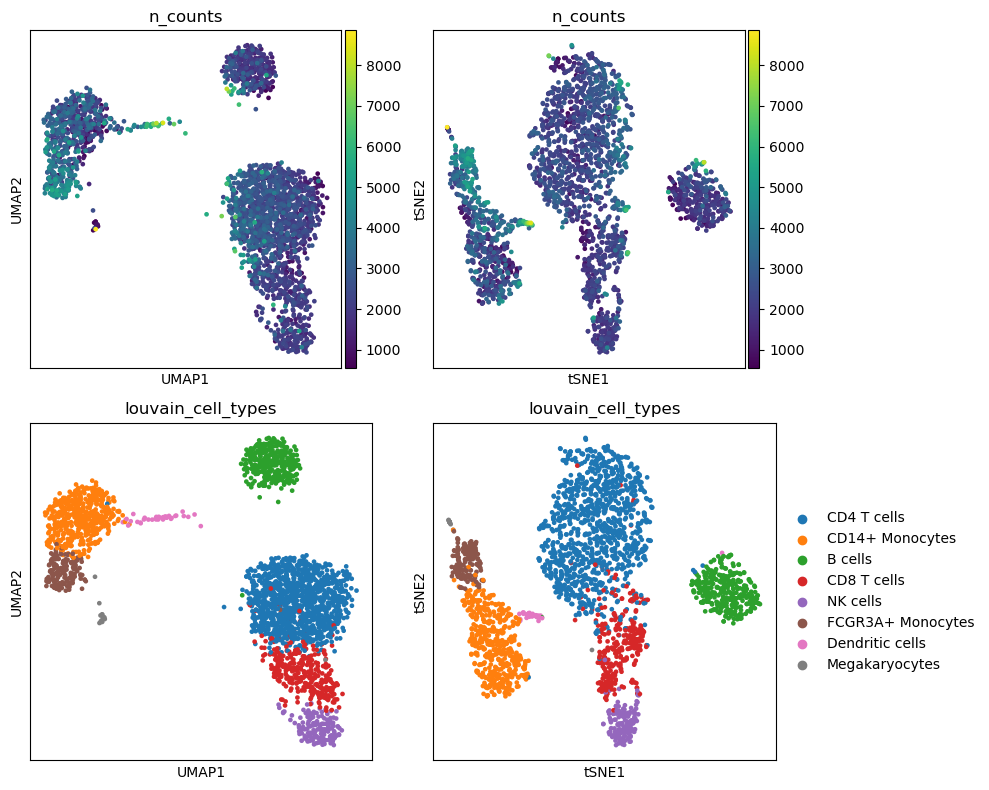

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt

# Assuming 'pbmc' is your AnnData object

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Adjust figsize as needed

# Plot UMAP with n_counts on the first row
sc.pl.umap(pbmc, color='n_counts', ax=axs[0, 0], show=False)
sc.pl.tsne(pbmc, color='n_counts', ax=axs[0, 1], show=False)

# Plot UMAP with louvain_cell_types on the second row
sc.pl.umap(pbmc, color='louvain_cell_types', ax=axs[1, 0], legend_loc=None, show=False)
sc.pl.tsne(pbmc, color='louvain_cell_types', ax=axs[1, 1], show=False)

# Adjust layout
plt.tight_layout()
plt.show()


Before including our improved scatter functions, we wanted to add additional information in the dinamic plotting. When generating the plot, it would show the x and y coordinates in the sliding wundow. We wanted to modify that information and decided to show *the most expressed genes* of that cell, which is why we created the following function. It can also be used for other calculations.

In [6]:
import numpy as np
import pandas as pd

def top_expressed_genes(adata, x_coord, y_coord, graph_type, n_genes=5):
    """
    Function to retrieve top expressed genes in a cell based on its UMAP/PCA/t-SNE coordinates.

    Parameters:
    - adata (anndata.AnnData): Annotated data object containing the PBMC data.
    - x_coord (float): X-coordinate of the map.
    - y_coord (float): Y-coordinate of the map.
    - graph_type (str): Type of graph to which the coordinate correspond ('umap', 'pca', or 'tsne').
    - n_genes (int): Number of top expressed genes to retrieve.

    Returns:
    - top_genes (list): List of top expressed genes in the specified cell.
    """

    if graph_type == "umap":
        nearest_cell_index = ((adata.obsm['X_umap'] - np.array([x_coord, y_coord]))**2).sum(axis=1).argmin()
    elif graph_type == "pca":
        nearest_cell_index = ((adata.obsm['X_pca'] - np.array([x_coord, y_coord]))**2).sum(axis=1).argmin()
    elif graph_type == "tsne":
        nearest_cell_index = ((adata.obsm['X_tsne'] - np.array([x_coord, y_coord]))**2).sum(axis=1).argmin()
    else:
        raise ValueError("Invalid graph type. Choose 'umap', 'pca', or 'tsne'.")

    cell_expression = adata.X[nearest_cell_index].toarray().flatten()

    sorted_genes_indices = cell_expression.argsort()[::-1][:n_genes]

    top_genes = [adata.var_names[i] for i in sorted_genes_indices]

    return top_genes

In [28]:
umap_x = -3.7
umap_y = 8.39
top_expressed_genes(pbmc, umap_x, umap_y, "tsne", n_genes=5)

['MALAT1', 'PNRC1', 'RPL7A', 'RPS2', 'RPS6']

### UMAP

**UMAP**, which stands for Uniform Manifold Approximation and Projection, is a dimensionality reduction technique used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. It is particularly effective for preserving local and global structure in the data, making it a popular choice for exploratory data analysis and visualization tasks, especially in the field of single-cell genomics.

The decision to include a dynamic version of the UMAP visualization function with four methods stems from the diverse needs and preferences of users when exploring and interpreting single-cell genomics data. Here's a breakdown of why each method was included:

1. **Clusters**: Single-cell RNA sequencing data often contains distinct cell populations or clusters, which can represent different cell types or states. Visualizing these clusters using UMAP helps researchers identify and characterize these populations based on gene expression patterns. Including a dynamic version with this method allows users to interactively explore the data, hover over clusters to see top marker genes, and gain insights into the biological significance of each cluster.

2. **Total Counts (n_counts)**: Understanding the total counts of each cell in the dataset is essential for quality control and normalization steps in single-cell RNA sequencing analysis. Visualizing the total counts using UMAP provides insights into the distribution of sequencing depth across cells and can help identify potential outliers or technical artifacts. The dynamic version with this method allows users to visualize the distribution of total counts with a color gradient, making it easier to spot patterns and anomalies in the data.

3. **Bulk Labels**: In addition to clustering, single-cell RNA sequencing data may also include bulk labels or annotations that assign cell types or states based on prior knowledge or experimental conditions. Visualizing these bulk labels using UMAP helps validate clustering results, compare different datasets, or investigate the effects of experimental perturbations on cell populations. Including a dynamic version with this method enables users to interactively explore the annotations and gain insights into the biological context of the data.

4. **Explore Genes**: Marker genes play a crucial role in identifying cell types or states and understanding gene regulatory networks in single-cell genomics data. Allowing users to dynamically explore marker genes using UMAP facilitates hypothesis generation and testing by visualizing the expression patterns of selected genes across cells. This method empowers users to investigate the role of specific genes in defining cell identities or driving biological processes within the dataset.

By offering a dynamic version of the UMAP visualization function with these four methods, the tutorial aims to provide users with a comprehensive toolkit for exploring and interpreting single-cell genomics data, enabling them to gain deeper insights into the underlying biological mechanisms and heterogeneity of cellular populations.

In [29]:
import pandas as pd
import hvplot.pandas
import ipywidgets as widgets
from IPython.display import display, clear_output

def umap_din(pbmc, visualization_option):
    """
    Generate a UMAP scatter plot based on the specified visualization option.

    Parameters:
    - pbmc (anndata.AnnData): The AnnData object containing the data.
    - visualization_option (str): The visualization option to choose from:
        - "clusters": Plot based on cluster labels.
        - "n_counts": Plot based on the total counts of each cell.
        - "bulk_labels": Plot based on labels for bulk cell types.
        - "explore_genes": Plot based on marker genes. Includes a menu to select genes more easily.

    Returns:
    - scatter_plot (hvplot): The generated scatter plot using hvplot.
    """

    # Extract coordinates data from the AnnData object
    umap_x = pbmc.obsm["X_umap"][:, 0]
    umap_y = pbmc.obsm["X_umap"][:, 1]
    
    if visualization_option == "clusters":
        if "louvain" in pbmc.obs.columns:
            labels = pbmc.obs["louvain"]
        elif "louvain_cell_types" in pbmc.obs.columns:
            labels = pbmc.obs["louvain_cell_types"]
        else:
            raise ValueError("No cluster labels found in AnnData object.")
            
        # Create a DataFrame for hvplot
        data = pd.DataFrame({"UMAP_X": umap_x, "UMAP_Y": umap_y, "Labels": labels})
        top_genes = data.apply(lambda row: ', '.join(top_expressed_genes(pbmc,row["UMAP_X"], row["UMAP_Y"], "umap")), axis=1)
        data["Top_5_Genes"] = top_genes

        scatter_plot = data.hvplot.scatter(x="UMAP_X", y="UMAP_Y", by="Labels", hover_cols=["Top_5_Genes"])
            
    elif visualization_option == "n_counts":
        labels = pbmc.obs["n_counts"]
        data = pd.DataFrame({"UMAP_X": umap_x, "UMAP_Y": umap_y, "Counts": labels})
        # we add a gradient color bar
        scatter_plot = data.hvplot.scatter(x="UMAP_X", y="UMAP_Y", c="Counts", cmap="viridis", colorbar=True, hover_cols=["Counts"])
            
            
    elif visualization_option == "bulk_labels":
        labels = pbmc.obs["bulk_labels"]
        data = pd.DataFrame({"UMAP_X": umap_x, "UMAP_Y": umap_y, "Labels": labels})
        # Create and display the scatter plot using hvplot.scatter
        scatter_plot = data.hvplot.scatter(x="UMAP_X", y="UMAP_Y", by="Labels")
        
    elif visualization_option == "explore_genes":
        # Define a function to update scatter plot based on selected gene
        def update_umap(change):
            selected_gene = change.new
            sc.pl.umap(pbmc, color=selected_gene)

        # Create dropdown widget for gene selection
        gene_dropdown = widgets.Dropdown(
            options=pbmc.var_names.tolist(),
            description='Select Gene:',
            disabled=False,
        )

        # Attach the update function to the dropdown's event
        gene_dropdown.observe(update_umap, names='value')

        # Display dropdown widget
        display(gene_dropdown)
        # Return None as scatter_plot since it will be dynamically updated
        scatter_plot = None
        
    else:
        raise ValueError("Invalid visualization option. Please choose from 'clusters', 'n_counts', 'bulk_labels', or 'explore_genes'.")

    return scatter_plot


Now we can visualize what this function returns. 

In [9]:
umap_din(pbmc, visualization_option="clusters")

:NdOverlay   [Labels]
   :Scatter   [UMAP_X]   (UMAP_Y,Top_5_Genes)

In [10]:
umap_din(pbmc, visualization_option="n_counts")

:Scatter   [UMAP_X]   (UMAP_Y,Counts)

Dropdown(description='Select Gene:', options=('LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'HES4', 'ISG15', 'AGR…

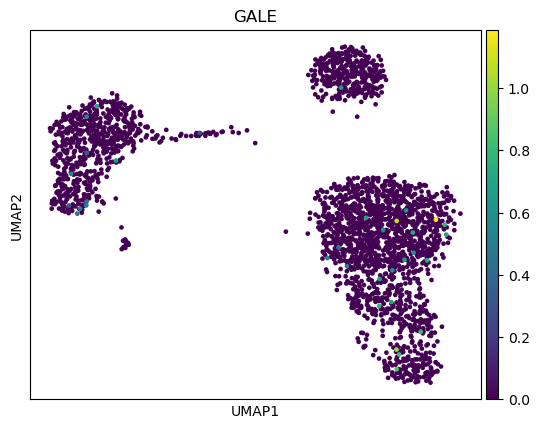

In [11]:
umap_din(pbmc, visualization_option="explore_genes")

### tSNE

**t-SNE**, short for t-distributed Stochastic Neighbor Embedding, is another popular dimensionality reduction technique used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. Like UMAP, t-SNE is widely used in exploratory data analysis and visualization tasks, particularly in the field of single-cell genomics. We included the same methos that the umap funciton which allows them to be compared.

**Why include both?** UMAP and t-SNE are effective dimensionality reduction techniques for visualizing high-dimensional data, they may highlight different aspects of the data and produce distinct clustering patterns due to differences in their algorithms. Offering dynamic versions of both UMAP and t-SNE visualization functions with four methods each provides users with a comprehensive toolkit for exploring and interpreting single-cell genomics data, allowing them to gain deeper insights into the heterogeneity and biological mechanisms underlying cellular populations.

t-SNE is preferred when the main goal is to visualize and explore complex local structures in the data, especially for identifying clusters or cell types. On the other hand, UMAP is preferred when you need a faster, more scalable method that preserves both local and global structures, making it suitable for general data exploration and visualization tasks.

In [21]:
import pandas as pd
import hvplot.pandas
import ipywidgets as widgets
from IPython.display import display, clear_output

def tsne_din(pbmc, visualization_option):
    """
    Generate a t-SNE scatter plot based on the specified visualization option.

    Parameters:
    - pbmc (anndata.AnnData): The AnnData object containing the data.
    - visualization_option (str): The visualization option to choose from:
        - "clusters": Plot based on cluster labels.
        - "n_counts": Plot based on the total counts of each cell.
        - "bulk_labels": Plot based on labels for bulk cell types.
        - "explore_genes": Plot based on marker genes. Includes a menu to select genes more easily.

    Returns:
    - scatter_plot (hvplot): The generated scatter plot using hvplot.
    """

    # Extract coordinates data from the AnnData object
    tsne_x = pbmc.obsm["X_tsne"][:, 0]
    tsne_y = pbmc.obsm["X_tsne"][:, 1]
    
    if visualization_option == "clusters":
        if "louvain" in pbmc.obs.columns:
            labels = pbmc.obs["louvain"]
        elif "louvain_cell_types" in pbmc.obs.columns:
            labels = pbmc.obs["louvain_cell_types"]
        else:
            raise ValueError("No cluster labels found in AnnData object.")
            
        # Create a DataFrame for hvplot
        data = pd.DataFrame({"tSNE_X": tsne_x, "tSNE_Y": tsne_y, "Labels": labels})
        top_genes = data.apply(lambda row: ', '.join(top_expressed_genes(pbmc,row["tSNE_X"], row["tSNE_Y"], "tsne")), axis=1)
        data["Top_5_Genes"] = top_genes

        scatter_plot = data.hvplot.scatter(x="tSNE_X", y="tSNE_Y", by="Labels", hover_cols=["Top_5_Genes"])
            
    elif visualization_option == "n_counts":
        labels = pbmc.obs["n_counts"]
        data = pd.DataFrame({"tSNE_X": tsne_x, "tSNE_Y": tsne_y, "Counts": labels})
        # we add a gradient color bar
        scatter_plot = data.hvplot.scatter(x="tSNE_X", y="tSNE_Y", c="Counts", cmap="viridis", colorbar=True, hover_cols=["Counts"])
            
            
    elif visualization_option == "bulk_labels":
        labels = pbmc.obs["bulk_labels"]
        data = pd.DataFrame({"tSNE_X": tsne_x, "tSNE_Y": tsne_y, "Labels": labels})
        # Create and display the scatter plot using hvplot.scatter
        scatter_plot = data.hvplot.scatter(x="tSNE_X", y="tSNE_Y", by="Labels")
        
    elif visualization_option == "explore_genes":
        # Define a function to update scatter plot based on selected gene
        def update_tsne(change):
            selected_gene = change.new
            sc.pl.tsne(pbmc, color=selected_gene)

        # Create dropdown widget for gene selection
        gene_dropdown = widgets.Dropdown(
            options=pbmc.var_names.tolist(),
            description='Select Gene:',
            disabled=False,
        )

        # Attach the update function to the dropdown's event
        gene_dropdown.observe(update_tsne, names='value')

        # Display dropdown widget
        display(gene_dropdown)
        # Return None as scatter_plot since it will be dynamically updated
        scatter_plot = None
        
    else:
        raise ValueError("Invalid visualization option. Please choose from 'clusters', 'n_counts', 'bulk_labels', or 'explore_genes'.")

    return scatter_plot


In [15]:
tsne_din(pbmc, visualization_option="clusters")

:NdOverlay   [Labels]
   :Scatter   [tSNE_X]   (tSNE_Y,Top_5_Genes)

In [19]:
tsne_din(pbmc, visualization_option="n_counts")

:Scatter   [tSNE_X]   (tSNE_Y,Counts)

Dropdown(description='Select Gene:', options=('LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'HES4', 'ISG15', 'AGR…

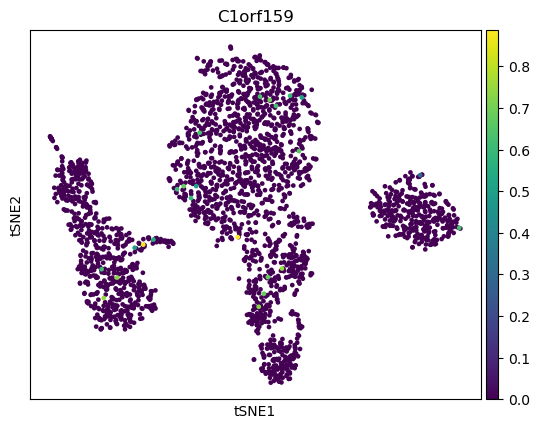

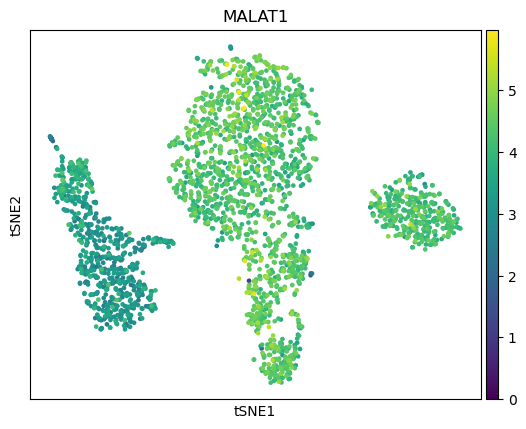

In [22]:
tsne_din(pbmc, visualization_option="explore_genes")

# Other possibilities for dimentionality reduction
We want to explore if amongst the genes or cell types, we can eliminate some that may be less interesting for the results. In particular, eliminating non relevant data allows to recalculate the data for UMAP/PCA or t-SNE which may give more meaningfull results (better cluster distinction). Therefore we decided to generate a new function which shows the user the attributes of the data that may help him/her to filter unnecessary data. 

In [23]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

def dimensionality_reduction(pbmc, input_data):
    """
    Performs a data reduction based on the input_data attributes.

    Parameters:
        pbmc (anndata.AnnData): Anndata object containing the data.
        input_data (str): Either 'highly_variable' or 'cell_types'. It corresponds to the parameter used for filtering the data.

    Returns:
        anndata.AnnData: Anndata object with dimensionality reduction results.
    """
    pbmc_red = pbmc.copy()
    
    if input_data == 'highly_variable':
        # the plot helps the scientitst decide if it is useful to delete some data
        value_counts = pbmc.var["highly_variable"].value_counts()
        value_counts_df = pd.DataFrame(value_counts).reset_index()
        value_counts_df.columns = ['highly_variable', 'count']
        highly_variable_genes = pbmc.var.index[pbmc.var['highly_variable']].tolist()
        not_highly_variable_genes = pbmc.var.index[~pbmc.var['highly_variable']].tolist()
        value_counts_df['genes'] = ['-'.join(highly_variable_genes) if x else '-'.join(not_highly_variable_genes) for x in value_counts_df['highly_variable']]
        
        # Generating bar plot using Matplotlib
        plt.figure(figsize=(5,4))
        # Count each category
        plt.bar(value_counts_df['highly_variable'], value_counts_df['count'])
        plt.ylabel('Count')
        plt.title('Highly Variable Genes')
        plt.xticks(value_counts_df['highly_variable'], ['Not Highly Variable', 'Highly Variable'])
        plt.show()
        
        # the scientist decides if he/she eliminates the data
        delete_not_hv_genes = input("Do you want to delete not highly variable genes? (yes/no): ")
        if delete_not_hv_genes.lower() == 'yes':
            pbmc_red = pbmc_red[:, pbmc_red.var['highly_variable']]
        elif delete_not_hv_genes.lower() != 'no':
            raise ValueError("Invalid input. Please enter 'yes' or 'no'.")
        
        # recalculate the diferent matrix with the data left
        sc.pp.pca(pbmc_red)
        sc.pp.neighbors(pbmc_red)
        sc.tl.umap(pbmc_red)
        sc.tl.tsne(pbmc_red)
        
    elif input_data == 'cell_types':
        # Display bar plot of cell type counts
        cell_type_counts = pbmc.obs['louvain_cell_types'].value_counts()
        cell_type_counts.plot(kind='bar')
        plt.ylabel('Count')
        plt.title('Cell Type Counts')
        plt.xticks(rotation=90)
        plt.show()
        
        # Display list of cell types
        cell_types = pbmc.obs['louvain_cell_types'].unique()
        print("Cell Types:")
        for idx, cell_type in enumerate(cell_types, start=1):
            print(f"{idx}. {cell_type}")
        
        # ask you cell type to delete
        delete_cell_type_idx = input(f"Which cell type do you want to delete? (Enter the corresponding number) [1-{len(cell_types)}]: ")
        try:
            delete_cell_type_idx = int(delete_cell_type_idx)
            if delete_cell_type_idx < 1 or delete_cell_type_idx > len(cell_types):
                raise ValueError("Invalid cell type index.")
        except ValueError:
            raise ValueError("Invalid input. Please enter a valid number.")
        
        # delete according to the users input
        delete_cell_type = cell_types[delete_cell_type_idx - 1]
        print(f"Deleting cell type: {delete_cell_type}")
        
        pbmc_red = pbmc_red[pbmc_red.obs['louvain_cell_types'] != delete_cell_type]
        
        # recalculate the diferent matrix with the data left
        sc.pp.neighbors(pbmc_red)
        sc.tl.umap(pbmc_red)
        sc.tl.tsne(pbmc_red)
    else:
        raise ValueError("Invalid input_data. Please provide either 'highly_variable' or 'cell_types'.")
    
    return pbmc_red

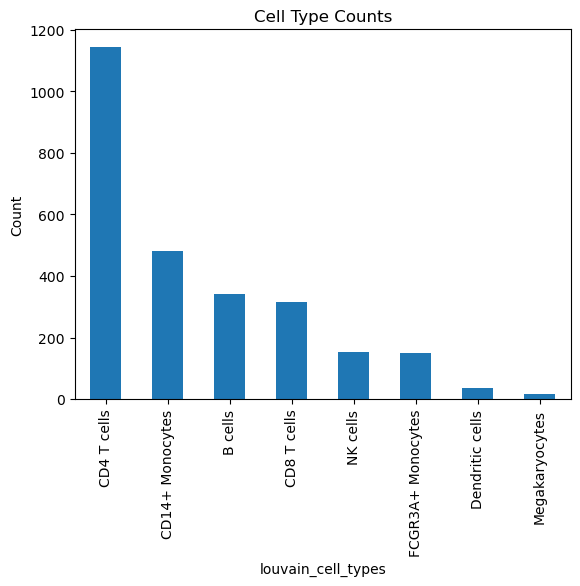

Cell Types:
1. CD4 T cells
2. B cells
3. CD14+ Monocytes
4. NK cells
5. CD8 T cells
6. FCGR3A+ Monocytes
7. Dendritic cells
8. Megakaryocytes
Which cell type do you want to delete? (Enter the corresponding number) [1-8]: 4
Deleting cell type: NK cells


In [36]:
new_anndata = dimensionality_reduction(pbmc,'cell_types')

In [37]:
import matplotlib.pyplot as plt

# Assuming 'pbmc' and 'new_anndata' are your AnnData objects

# Plot for pbmc dataset
scatter_plot_pbmc = umap_din(pbmc, visualization_option="clusters")

# Plot for new_anndata dataset
scatter_plot_new_anndata = umap_din(new_anndata, visualization_option="clusters")

scatter_plot_pbmc + scatter_plot_new_anndata

:Layout
   .NdOverlay.I  :NdOverlay   [Labels]
      :Scatter   [UMAP_X]   (UMAP_Y,Top_5_Genes)
   .NdOverlay.II :NdOverlay   [Labels]
      :Scatter   [UMAP_X]   (UMAP_Y,Top_5_Genes)

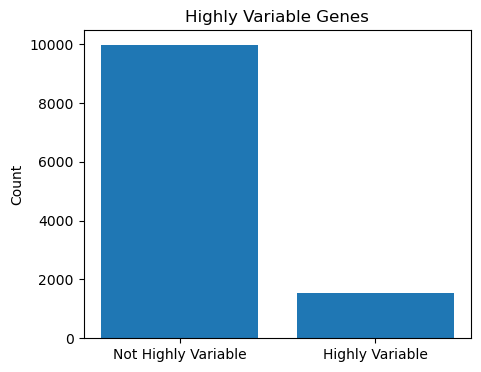

Do you want to delete not highly variable genes? (yes/no): yes


C:\Users\34619\anaconda3\Lib\site-packages\scanpy\preprocessing\_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


In [38]:
new_anndata = dimensionality_reduction(pbmc,'highly_variable')

In [39]:
import matplotlib.pyplot as plt

scatter_plot_pbmc = umap_din(pbmc, visualization_option="clusters")
scatter_plot_new_anndata = umap_din(new_anndata, visualization_option="clusters")

scatter_plot_pbmc+scatter_plot_new_anndata

:Layout
   .NdOverlay.I  :NdOverlay   [Labels]
      :Scatter   [UMAP_X]   (UMAP_Y,Top_5_Genes)
   .NdOverlay.II :NdOverlay   [Labels]
      :Scatter   [UMAP_X]   (UMAP_Y,Top_5_Genes)

In [15]:
new_anndata

AnnData object with n_obs × n_vars = 2638 × 11505
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain_cell_types'
    var: 'gene_names', 'n_cells', 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'pca', 'hvg', 'louvain_cell_types_colors', 'neighbors', 'umap', 'tsne'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'distances_all', 'distances', 'connectivities'

As we can see eliminating data changes drastically the saphe of clusters and the distance with the others. This decision of what to eliminate can be base in advances made with other tools or on previous knowledge, not randomly.

# Export functions
The anndata structure in which this data is stored may seem complicated for unexperienced programmers. Therefore this upgraded package includes functions to export the individuals matrices and other useful informations that form the AnnData object.
### Export counts (normalizad or raw)

In [16]:
pbmc

AnnData object with n_obs × n_vars = 2638 × 11505
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain_cell_types'
    var: 'gene_names', 'n_cells', 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'pca', 'hvg', 'louvain_cell_types_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'raw'
    obsp: 'distances_all'

In [17]:
def export_data_to_csv(filename, pbmc, info):
    """
    Export data from the complex AnnData data structure to a CSV file.

    Parameters:
        filename (str): The name of the CSV file to be exported.
        pbmc (AnnData): An AnnData object containing the single-cell data.
        info (str): Type of information to export. Choose from:
            - 'raw': Export raw expression data.
            - 'normalized': Export normalized expression data.
            - 'variable_genes': Export information about variable genes and related information.
            - 'umap': Export UMAP coordinates.
            - 'tsne': Export tSNE coordinates.
            - 'pca': Export PCA coordinates.

    Raises:
        ValueError: If the 'info' parameter is not one of the valid options.

    Returns:
        None
    """
    if info == "raw":
        data = pd.DataFrame(pbmc.layers['raw'].todense(), columns=pbmc.var_names)
    elif info == "normalized":
        data = pd.DataFrame(pbmc.X.todense(), columns=pbmc.var_names)
    elif info == "variable genes":
        data = pbmc.var[['gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm']]
    elif info == "umap":
        ids = pbmc.obs_names
        x_coord = pbmc.obsm["X_umap"][:, 0]
        y_coord = pbmc.obsm["X_umap"][:, 1]
        data = pd.DataFrame({
        "ID": ids,
        "UMAP_X": x_coord,
        "UMAP_Y": y_coord
    })
    elif info == "tsne":
        ids = pbmc.obs_names
        x_coord = pbmc.obsm["X_tsne"][:, 0]
        y_coord = pbmc.obsm["X_tsne"][:, 1]
        data = pd.DataFrame({
        "ID": ids,
        "tSNE_X": x_coord,
        "tSNE_Y": y_coord})
    elif info == "pca":
        ids = pbmc.obs_names
        x_coord = pbmc.obsm["X_pca"][:, 0]
        y_coord = pbmc.obsm["X_pca"][:, 1]
        data = pd.DataFrame({
        "ID": ids,
        "PCA_X": x_coord,
        "PCA_Y": y_coord})
    else:
        raise ValueError("Invalid info type. Choose 'raw', 'normalized', 'variable genes', 'umap', 'pca', or 'tsne'.")

    data.to_csv(filename + ".csv", index=False)
    print("Exported UMAP data to CSV file:", filename + ".csv")

In [18]:
export_data_to_csv('raw_data', pbmc, 'raw')
export_data_to_csv('norm_data', pbmc, 'normalized')
export_data_to_csv('var_genes_data', pbmc, 'variable genes')
export_data_to_csv('umap_data', pbmc, 'umap')
export_data_to_csv('tsne_data', pbmc, 'tsne')
export_data_to_csv('pca_data', pbmc, 'pca')

Exported UMAP data to CSV file: raw_data.csv
Exported UMAP data to CSV file: norm_data.csv
Exported UMAP data to CSV file: var_genes_data.csv
Exported UMAP data to CSV file: umap_data.csv
Exported UMAP data to CSV file: tsne_data.csv
Exported UMAP data to CSV file: pca_data.csv


### Export coordinates and most expressed genes 

In [19]:
def export_scatter_data_to_csv(filename, pbmc, plot, num_top_genes=5):
    ids = pbmc.obs_names

    if plot == "umap":
        x_coord = pbmc.obsm["X_umap"][:, 0]
        y_coord = pbmc.obsm["X_umap"][:, 1]
    elif plot == "tsne":
        x_coord = pbmc.obsm["X_tsne"][:, 0]
        y_coord = pbmc.obsm["X_tsne"][:, 1]
    elif plot == "pca":
        x_coord = pbmc.obsm["X_pca"][:, 0]
        y_coord = pbmc.obsm["X_pca"][:, 1]
    else:
        raise ValueError("Invalid plot type. Choose 'umap', 'pca', r 'tsne'.")

    top_genes = []
    for x, y in zip(x_coord, y_coord):
        top_genes.append(top_expressed_genes(pbmc, x, y, plot, num_top_genes))

    umap_data = pd.DataFrame({
        "ID": ids,
        "UMAP_X": x_coord,
        "UMAP_Y": y_coord,
        "Top_Expressed_Genes": top_genes
    })

    umap_data.to_csv(filename + ".csv", index=False)
    print("Exported UMAP data to CSV file:", filename + ".csv")

In [20]:
export_scatter_data_to_csv("data_umap", pbmc, "umap")

Exported UMAP data to CSV file: data_umap.csv
